### ViT VQ-GAN trained on ImageNet

In [1]:
import paintmind as pm
from PIL import Image
import glob
import random
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import torchvision.transforms as transforms
import warnings
warnings.filterwarnings("ignore")

/home/hitesh/anaconda3/envs/fourm/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/hitesh/anaconda3/envs/fourm/lib/python3.9/site-packages/kornia/feature/lightglue.py:44: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @torch.cuda.amp.custom_fwd(cast_inputs=torch.float32)


In [2]:
images = glob.glob("/mnt/SSD1/Niantic/feat_im/train/**/**/*.png")
seed_number = 48 
random.seed(seed_number)
random.shuffle(images)
selected_images = images[:5]

In [4]:
selected_images

['/mnt/SSD1/Niantic/feat_im/train/s00043/seq1/frame_00195_feature.png',
 '/mnt/SSD1/Niantic/feat_im/train/s00309/seq1/frame_00548_feature.png',
 '/mnt/SSD1/Niantic/feat_im/train/s00118/seq0/frame_00121_feature.png',
 '/mnt/SSD1/Niantic/feat_im/train/s00188/seq0/frame_00137_feature.png',
 '/mnt/SSD1/Niantic/feat_im/train/s00281/seq1/frame_00266_feature.png']

In [7]:
model = pm.create_model(arch='vqgan', version='vit-s-vqgan', pretrained=True, checkpoint_path='/mnt/SSD1/Niantic/tokenizers/RGB/vit.pt')
tensor_outputs = []
for image in tqdm(selected_images):
    img = Image.open(image).convert('RGB')
    img = pm.stage1_transform(is_train=False)(img)
    z, _, _ = model.encode(img.unsqueeze(0))
    rec = model.decode(z).squeeze(0)
    rec = torch.clamp(rec, -1., 1.)
    tensor_outputs.append(rec)

0it [00:00, ?it/s]


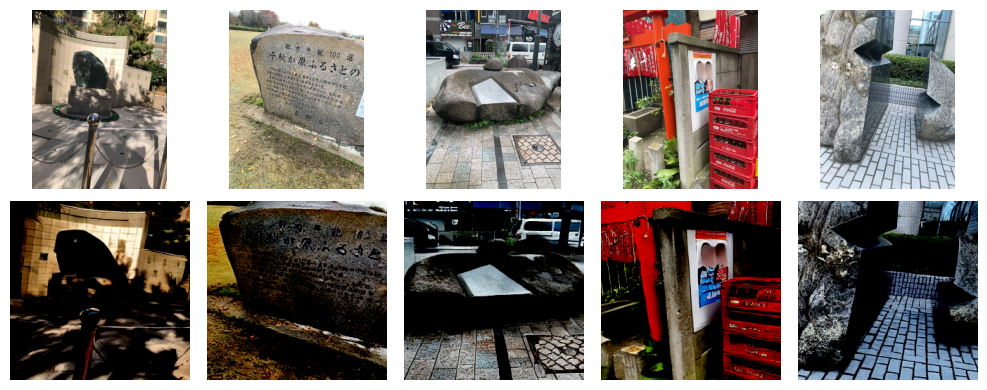

In [41]:
fig, axs = plt.subplots(2, 5, figsize=(10, 4))

for i, image_path in enumerate(selected_images):
    image = Image.open(image_path)
    axs[0, i].imshow(image)
    axs[0, i].axis('off')

for i, tensor in enumerate(tensor_outputs):
    tensor = torch.clamp(tensor, 0, 1)
    axs[1, i].imshow(tensor.permute(1, 2, 0).detach().numpy())
    axs[1, i].axis('off')
plt.tight_layout() 
plt.show()

### ml-4M RGB Tokenizer

In [40]:
from fourm.vq.vqvae import DiVAE
from PIL import Image
from torchvision import transforms
from fourm.utils import denormalize, IMAGENET_INCEPTION_MEAN, IMAGENET_INCEPTION_STD
from torchvision.transforms import Normalize
transform = transforms.ToTensor()
resize = transforms.Resize((224, 224))

In [30]:
tok = DiVAE.from_pretrained('EPFL-VILAB/4M_tokenizers_normal_8k_224-448').cuda()
normalize = Normalize(mean=IMAGENET_INCEPTION_MEAN, std=IMAGENET_INCEPTION_STD)

In [31]:
tensors_b3hw = []
for image_path in selected_images :
    image = Image.open(image_path)
    rgb_b3hw = transform(resize(image)).unsqueeze(0)  
    tensors_b3hw.append(rgb_b3hw)
stacked_tensors_b3hw = torch.cat(tensors_b3hw, dim=0)

In [32]:
_, _, tokens = tok.encode(normalize(stacked_tensors_b3hw).cuda())
image_size = rgb_b3hw.shape[-1]
output_rgb_b3hw  = tok.decode_tokens(tokens, image_size=image_size)

In [33]:
out_rgb_b3hw = denormalize(output_rgb_b3hw, mean=IMAGENET_INCEPTION_MEAN, std=IMAGENET_INCEPTION_STD)

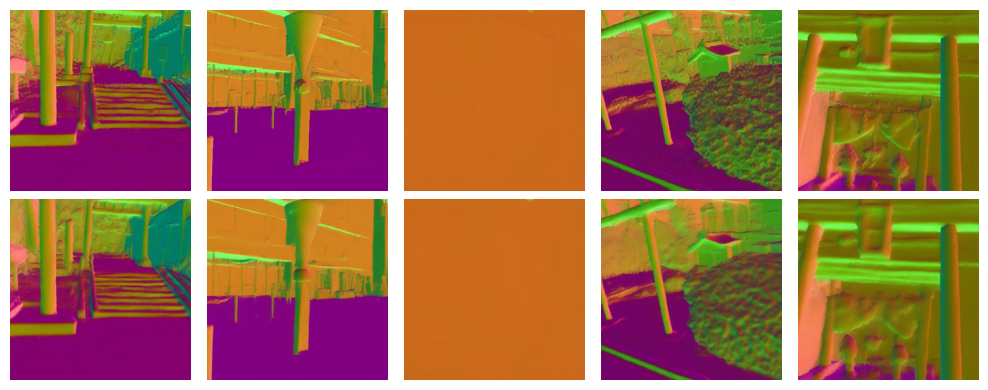

In [12]:
fig, axs = plt.subplots(2, 5, figsize=(10, 4))

for i, image_path in enumerate(selected_images):
    image = Image.open(image_path)
    axs[0, i].imshow(image)
    axs[0, i].axis('off')

for i, tensor in enumerate(out_rgb_b3hw):
    tensor = torch.clamp(tensor, 0, 1)
    axs[1, i].imshow(tensor.cpu().permute(1, 2, 0).detach().numpy())
    axs[1, i].axis('off')
plt.tight_layout() 
plt.show()

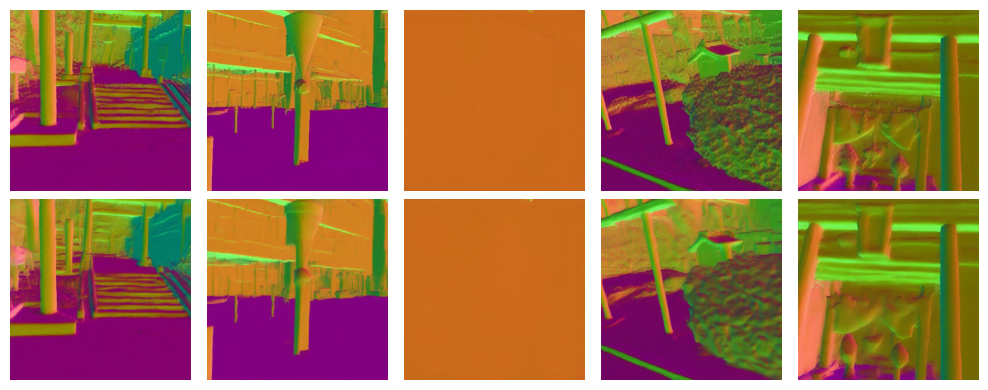

In [34]:
fig, axs = plt.subplots(2, 5, figsize=(10, 4))

for i, image_path in enumerate(selected_images):
    image = Image.open(image_path)
    axs[0, i].imshow(image)
    axs[0, i].axis('off')

for i, tensor in enumerate(out_rgb_b3hw):
    tensor = torch.clamp(tensor, 0, 1)
    axs[1, i].imshow(tensor.cpu().permute(1, 2, 0).detach().numpy())
    axs[1, i].axis('off')
plt.tight_layout() 
plt.show()

In [35]:
import numpy as np
le = np.load('/mnt/SSD1/Niantic/surface_token/train/part_12/s00106_seq1_frame_00072.npy')

In [38]:
# le

### clip tokenizer

In [3]:
import numpy as np
from PIL import Image
import torch
from pathlib import Path

def reconstruct_tensor(img_path):
    img_path = Path(img_path)
    img_file = img_path.with_suffix('.jpg')
    txt_file = img_path.with_suffix('.txt')
    
    img = Image.open(img_file)
    normalized_slice = np.array(img, dtype=np.float32)

    min_max_vals = np.loadtxt(txt_file)
    min_vals = min_max_vals[0, :]
    max_vals = min_max_vals[1, :]

    tensor_slice = normalized_slice / 255.0 * (max_vals - min_vals) + min_vals

    return torch.tensor(tensor_slice)

In [4]:
from fourm.vq.vqvae import VQVAE, DiVAE
from PIL import Image
import torch.nn as nn
from torchvision import transforms
from fourm.utils import denormalize, IMAGENET_INCEPTION_MEAN, IMAGENET_INCEPTION_STD
from torchvision.transforms import Normalize
transform = transforms.ToTensor()
resize = transforms.Resize((224, 224))

xFormers not available
xFormers not available


INFO:albumentations.check_version:A new version of Albumentations is available: 1.4.13 (you have 1.4.12). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
INFO:datasets:PyTorch version 2.4.0 available.


In [5]:
class ChannelReducer(nn.Module):
    def __init__(self):
        super(ChannelReducer, self).__init__()
        self.conv = nn.Conv2d(in_channels=768, out_channels=512, kernel_size=1)

    def forward(self, x):
        return self.conv(x)
channel_reducer = ChannelReducer().cuda()

In [6]:
tok = VQVAE.from_pretrained('EPFL-VILAB/4M_tokenizers_CLIP-B16_8k_224-448').cuda()
normalize = Normalize(mean=IMAGENET_INCEPTION_MEAN[0], std=IMAGENET_INCEPTION_STD[0])

In [8]:
image_path

'/mnt/SSD1/Niantic/clip/train/s00037/seq0/frame_00374.jpg'

In [9]:
tensors_b3hw = []
k = []
for image_path in selected_images:
    rgb_b3hw = reconstruct_tensor(image_path).to(dtype=torch.float32).cuda()  
    tensor_b3hw = rgb_b3hw[1:].view(1, 768, 14, 14) 
    tensors_b3hw.append(channel_reducer(tensor_b3hw))  
stacked_tensors_b3hw = torch.cat(tensors_b3hw).to(dtype=torch.float32).cuda()
_, _, tokens = tok.encode(normalize(stacked_tensors_b3hw).cuda())
image_size = rgb_b3hw.shape[-1]
output_rgb_b3hw = tok.decode_tokens(tokens, image_size=image_size)
out_rgb_b3hw = denormalize(output_rgb_b3hw, mean=IMAGENET_INCEPTION_MEAN[0:1], std=IMAGENET_INCEPTION_STD[0:1])

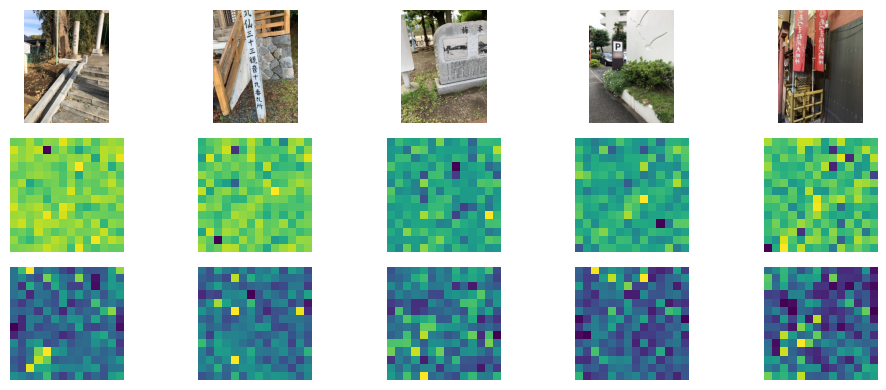

In [11]:
import matplotlib.pyplot as plt
import torch

# Function to sum channels and normalize for display
def sum_and_normalize_channels(tensor):
    # Sum along the channel dimension (axis=0)
    summed_tensor = torch.sum(tensor, dim=0)
    # Normalize to range [0, 1]
    min_val = summed_tensor.min()
    max_val = summed_tensor.max()
    normalized_tensor = (summed_tensor - min_val) / (max_val - min_val)
    return normalized_tensor

fig, axs = plt.subplots(3, 5, figsize=(10, 4))

for i, image_path in enumerate(selected_images):
    image = Image.open(image_path.replace('clip','data'))
    axs[0, i].imshow(image)
    axs[0, i].axis('off')

for i, tensor in enumerate(stacked_tensors_b3hw):
    summed_tensor = sum_and_normalize_channels(tensor)
    axs[1, i].imshow(summed_tensor.cpu().detach().numpy())
    axs[1, i].axis('off')

for i, tensor in enumerate(out_rgb_b3hw):
    summed_tensor = sum_and_normalize_channels(tensor)
    axs[2, i].imshow(summed_tensor.cpu().detach().numpy())
    axs[2, i].axis('off')

plt.tight_layout() 
plt.show()


In [ ]:
import shutil

# Define the source and destination file paths
source_file_path = '/mnt/SSD1/Niantic/clip/train/s00037/seq1/frame_00278.txt'
destination_file_path = '/mnt/SSD1/Niantic/clip/train/s00037/seq1/frame_00279.txt'

# Copy the contents of the source file to the destination file
shutil.copy(source_file_path, destination_file_path)

In [1]:
import glob
le_jpg = glob.glob("/mnt/SSD1/Niantic/clip_tok/train/**/*")
len(le_jpg)

522921

In [8]:
import glob
le_txt = glob.glob("/mnt/SSD1/Niantic/clip/train/**/**/*.txt")
len(le_txt)

148000

In [3]:
set1 = set(le_jpg)
le_txt_replaced = [filename.replace(".txt", ".jpg") for filename in le_txt]

set2 = set(le_txt_replaced)

# Find the difference
difference = set1 - set2

# Convert back to list if needed
result = list(difference)

print(result)

[]


### ImageBind Tokenizer

In [46]:
import numpy as np
from PIL import Image
import torch
from pathlib import Path

def reconstruct_tensor(img_path):
    img_path = Path(img_path)
    img_file = img_path.with_suffix('.jpg')
    txt_file = img_path.with_suffix('.txt')
    
    img = Image.open(img_file)
    normalized_slice = np.array(img, dtype=np.float32)
    print(normalized_slice.shape)
    min_max_vals = np.loadtxt(txt_file)
    min_vals = min_max_vals[0, :]
    max_vals = min_max_vals[1, :]
    print(min_vals.shape)
    tensor_slice = normalized_slice / 255.0 * (max_vals - min_vals) + min_vals

    return torch.tensor(tensor_slice)

In [44]:
images = glob.glob("/mnt/SSD1/Niantic/imagebind/train/**/**/*.jpg")
seed_number = 48 
random.seed(seed_number)
random.shuffle(images)
selected_images = images[:5]

In [43]:
from fourm.vq.vqvae import VQVAE, DiVAE
from PIL import Image
import torch.nn as nn
from torchvision import transforms
from fourm.utils import denormalize, IMAGENET_INCEPTION_MEAN, IMAGENET_INCEPTION_STD
from torchvision.transforms import Normalize
transform = transforms.ToTensor()
resize = transforms.Resize((224, 224))

In [34]:
class ChannelReducer(nn.Module):
    def __init__(self):
        super(ChannelReducer, self).__init__()
        self.conv = nn.Conv2d(in_channels=1280, out_channels=1280, kernel_size=1)

    def forward(self, x):
        return self.conv(x)
channel_reducer = ChannelReducer().cuda()

In [28]:
tok = VQVAE.from_pretrained('EPFL-VILAB/4M_tokenizers_ImageBind-H14_8k_224-448').cuda()
normalize = Normalize(mean=IMAGENET_INCEPTION_MEAN[0], std=IMAGENET_INCEPTION_STD[0])

In [47]:
tensors_b3hw = []
k = []
for image_path in selected_images:
    rgb_b3hw = reconstruct_tensor(image_path).to(dtype=torch.float32).cuda()  
    tensor_b3hw = rgb_b3hw[1:].view(1, 1280, 16, 16) 
    tensors_b3hw.append(channel_reducer(tensor_b3hw)) 

(257, 1280)
(1280,)
(257, 1280)
(1280,)
(257, 1280)
(1280,)
(257, 1280)
(1280,)
(257, 1280)
(1280,)


In [10]:
tensors_b3hw = []
k = []
for image_path in selected_images:
    rgb_b3hw = reconstruct_tensor(image_path).to(dtype=torch.float32).cuda()  
    tensor_b3hw = rgb_b3hw[1:].view(1, 1280, 16, 16) 
    tensors_b3hw.append(channel_reducer(tensor_b3hw))  
stacked_tensors_b3hw = torch.cat(tensors_b3hw).to(dtype=torch.float32).cuda()
_, _, tokens = tok.encode(normalize(stacked_tensors_b3hw).cuda())
image_size = rgb_b3hw.shape[-1]
output_rgb_b3hw = tok.decode_tokens(tokens, image_size=image_size)
out_rgb_b3hw = denormalize(output_rgb_b3hw, mean=IMAGENET_INCEPTION_MEAN[0:1], std=IMAGENET_INCEPTION_STD[0:1])

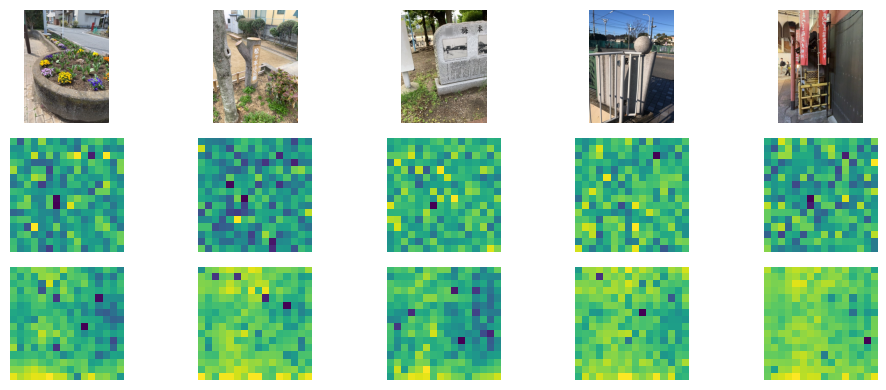

In [11]:
import matplotlib.pyplot as plt
import torch

# Function to sum channels and normalize for display
def sum_and_normalize_channels(tensor):
    # Sum along the channel dimension (axis=0)
    summed_tensor = torch.sum(tensor, dim=0)
    # Normalize to range [0, 1]
    min_val = summed_tensor.min()
    max_val = summed_tensor.max()
    normalized_tensor = (summed_tensor - min_val) / (max_val - min_val)
    return normalized_tensor

fig, axs = plt.subplots(3, 5, figsize=(10, 4))

for i, image_path in enumerate(selected_images):
    image = Image.open(image_path.replace('imagebind','data'))
    axs[0, i].imshow(image)
    axs[0, i].axis('off')

for i, tensor in enumerate(stacked_tensors_b3hw):
    summed_tensor = sum_and_normalize_channels(tensor)
    axs[1, i].imshow(summed_tensor.cpu().detach().numpy())
    axs[1, i].axis('off')

for i, tensor in enumerate(out_rgb_b3hw):
    summed_tensor = sum_and_normalize_channels(tensor)
    axs[2, i].imshow(summed_tensor.cpu().detach().numpy())
    axs[2, i].axis('off')

plt.tight_layout() 
plt.show()


In [14]:
stacked_tensors_b3hw.shape

torch.Size([5, 1024, 16, 16])

### DinoV2 Tokenizer

In [21]:
images = glob.glob("/mnt/SSD1/Niantic/feat_im/train/**/**/*.png")
seed_number = 480
random.seed(seed_number)
random.shuffle(images)
selected_images = images[:5]

In [4]:
import numpy as np
from PIL import Image
import torch
from pathlib import Path
import re

def parse_min_max(txt_file):
    min_vals = []
    max_vals = []
    
    with open(txt_file, 'r') as file:
        for line in file:
            # Extract min and max values using regex
            min_match = re.search(r'Min:\s*(-?\d+\.\d+)', line)
            max_match = re.search(r'Max:\s*(-?\d+\.\d+)', line)
            
            if min_match and max_match:
                min_vals.append(float(min_match.group(1)))
                max_vals.append(float(max_match.group(1)))
    
    return np.array(min_vals), np.array(max_vals)

def reconstruct_tensor(img_path):
    img_path = Path(img_path)
    img_file = img_path.with_suffix('.png')
    print(img_path)
    txt_file = str(img_path).replace("feature.png", "metadata.txt")
    
    img = Image.open(img_file)
    normalized_slice = np.array(img, dtype=np.float32).reshape(1369,1024)
    print(normalized_slice.shape)
    min_vals, max_vals = parse_min_max(txt_file)
    print(min_vals.shape)
    
    tensor_slice = normalized_slice / 255.0 * (max_vals - min_vals) + min_vals

    return torch.tensor(tensor_slice)



In [5]:
from fourm.vq.vqvae import VQVAE, DiVAE
from PIL import Image
import torch.nn as nn
from torchvision import transforms
from fourm.utils import denormalize, IMAGENET_INCEPTION_MEAN, IMAGENET_INCEPTION_STD
from torchvision.transforms import Normalize
transform = transforms.ToTensor()
resize = transforms.Resize((224, 224))

xFormers not available
xFormers not available


INFO:albumentations.check_version:A new version of Albumentations is available: 1.4.13 (you have 1.4.12). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
INFO:datasets:PyTorch version 2.4.0 available.


In [18]:
class ChannelReducer(nn.Module):
    def __init__(self):
        super(ChannelReducer, self).__init__()
        # Use a 1x1 convolution to expand channels from 1024 to 1280
        self.channel_expander = nn.Conv2d(in_channels=1024, out_channels=768, kernel_size=1)
        
        # Use a 3x3 convolution with stride 2 to reduce spatial dimensions
        self.spatial_reducer = nn.Conv2d(in_channels=768, out_channels=768, kernel_size=9, stride=2, padding=1)
    
    def forward(self, x):
        x = self.channel_expander(x)  
        x = self.spatial_reducer(x)   
        return x

# Create an instance of the modified ChannelReducer
channel_reducer = ChannelReducer().cuda()

In [8]:
tok = VQVAE.from_pretrained('EPFL-VILAB/4M_tokenizers_DINOv2-B14_8k_224-448').cuda()
normalize = Normalize(mean=IMAGENET_INCEPTION_MEAN[0], std=IMAGENET_INCEPTION_STD[0])

In [22]:
tensors_b3hw = []
k = []
for image_path in selected_images:
    rgb_b3hw = reconstruct_tensor(image_path).to(dtype=torch.float32).cuda()  
    tensor_b3hw = rgb_b3hw.view(1, 1024, 37, 37) 
    tensors_b3hw.append(channel_reducer(tensor_b3hw))  
    print(tensors_b3hw[0].shape)
stacked_tensors_b3hw = torch.cat(tensors_b3hw).to(dtype=torch.float32).cuda()
_, _, tokens = tok.encode(normalize(stacked_tensors_b3hw).cuda())
image_size = rgb_b3hw.shape[-1]
output_rgb_b3hw = tok.decode_tokens(tokens, image_size=image_size)
out_rgb_b3hw = denormalize(output_rgb_b3hw, mean=IMAGENET_INCEPTION_MEAN[0:1], std=IMAGENET_INCEPTION_STD[0:1])

/mnt/SSD1/Niantic/feat_im/train/s00341/seq0/frame_00132_feature.png
(1369, 1024)
(1024,)
torch.Size([1, 768, 16, 16])
/mnt/SSD1/Niantic/feat_im/train/s00037/seq1/frame_00405_feature.png
(1369, 1024)
(1024,)
torch.Size([1, 768, 16, 16])
/mnt/SSD1/Niantic/feat_im/train/s00364/seq0/frame_00579_feature.png
(1369, 1024)
(1024,)
torch.Size([1, 768, 16, 16])
/mnt/SSD1/Niantic/feat_im/train/s00205/seq1/frame_00418_feature.png
(1369, 1024)
(1024,)
torch.Size([1, 768, 16, 16])
/mnt/SSD1/Niantic/feat_im/train/s00028/seq1/frame_00358_feature.png
(1369, 1024)
(1024,)
torch.Size([1, 768, 16, 16])


In [24]:
tokens.shape

torch.Size([5, 16, 16])

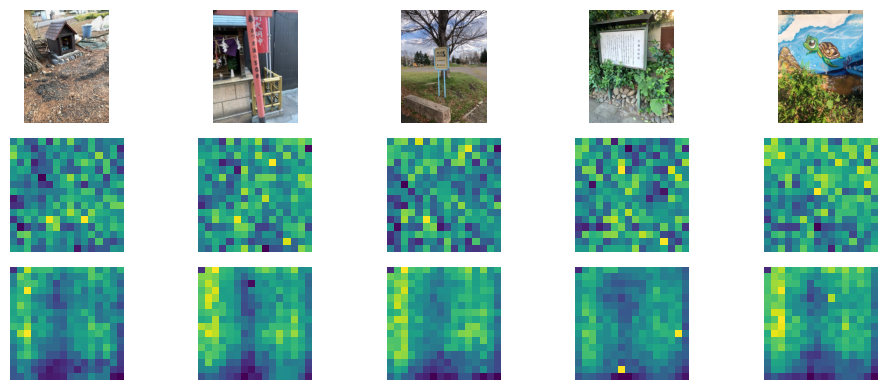

In [23]:
import matplotlib.pyplot as plt
import torch

# Function to sum channels and normalize for display
def sum_and_normalize_channels(tensor):
    # Sum along the channel dimension (axis=0)
    summed_tensor = torch.sum(tensor, dim=0)
    # Normalize to range [0, 1]
    min_val = summed_tensor.min()
    max_val = summed_tensor.max()
    normalized_tensor = (summed_tensor - min_val) / (max_val - min_val)
    return normalized_tensor

fig, axs = plt.subplots(3, 5, figsize=(10, 4))

for i, image_path in enumerate(selected_images):
    image = Image.open(image_path.replace('feat_im','data').replace('.png','.jpg').replace("_feature",''))
    axs[0, i].imshow(image)
    axs[0, i].axis('off')

for i, tensor in enumerate(stacked_tensors_b3hw):
    summed_tensor = sum_and_normalize_channels(tensor)
    axs[1, i].imshow(summed_tensor.cpu().detach().numpy())
    axs[1, i].axis('off')

for i, tensor in enumerate(out_rgb_b3hw):
    summed_tensor = sum_and_normalize_channels(tensor)
    axs[2, i].imshow(summed_tensor.cpu().detach().numpy())
    axs[2, i].axis('off')

plt.tight_layout() 
plt.show()


In [25]:
rgb_b3hw.shape

torch.Size([1369, 1024])

### Semantic Seg

In [1]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

In [2]:
import paintmind as pm
from PIL import Image
import glob
import random
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import torchvision.transforms as transforms
import warnings
warnings.filterwarnings("ignore")

/home/hitesh/anaconda3/envs/fourm/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/hitesh/anaconda3/envs/fourm/lib/python3.9/site-packages/kornia/feature/lightglue.py:44: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @torch.cuda.amp.custom_fwd(cast_inputs=torch.float32)


In [3]:
images = glob.glob("/mnt/SSD1/Niantic/semantic/train/**/**/*.png")
seed_number = 480
random.seed(seed_number)
random.shuffle(images)
selected_images = images[:5]

In [2]:
from fourm.vq.vqvae import VQVAE, DiVAE
from PIL import Image
import torch.nn as nn
from torchvision import transforms
from fourm.utils import denormalize, IMAGENET_INCEPTION_MEAN, IMAGENET_INCEPTION_STD
from torchvision.transforms import Normalize
transform = transforms.ToTensor()
resize = transforms.Resize((224, 224))

/home/hitesh/anaconda3/envs/fourm/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/hitesh/dualmapfree/4M_dataset_dev/ml-4m/fourm/vq/quantizers/quantize_lucid.py:263: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  @autocast(enabled = False)
/home/hitesh/dualmapfree/4M_dataset_dev/ml-4m/fourm/vq/quantizers/quantize_lucid.py:388: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  @autocast(enabled = False)


xFormers not available
xFormers not available


INFO:albumentations.check_version:A new version of Albumentations is available: 1.4.13 (you have 1.4.12). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
INFO:datasets:PyTorch version 2.4.0 available.


In [3]:
tok = VQVAE.from_pretrained('EPFL-VILAB/4M_tokenizers_semseg_4k_224-448').cuda()
normalize = Normalize(mean=IMAGENET_INCEPTION_MEAN[0], std=IMAGENET_INCEPTION_STD[0])

In [4]:
tensors_b3hw = []
for image_path in selected_images :
    image = Image.open(image_path)
    rgb_b3hw = transform(resize(image)).unsqueeze(0)  
    tensors_b3hw.append(rgb_b3hw)
stacked_tensors_b3hw = torch.cat(tensors_b3hw, dim=0).int()
squeezed_tensor = torch.squeeze(stacked_tensors_b3hw, dim=1)
squeezed_tensor.shape

NameError: name 'selected_images' is not defined

In [7]:
print(squeezed_tensor.dtype)
print(squeezed_tensor.min(), squeezed_tensor.max())


torch.int32
tensor(0, dtype=torch.int32) tensor(1, dtype=torch.int32)


In [8]:
_, _, tokens = tok.encode(squeezed_tensor.cuda())
image_size = rgb_b3hw.shape[-1]
output_rgb_b3hw  = tok.decode_tokens(tokens, image_size=image_size)


In [9]:
len(tokens[2])

14

In [10]:
out_rgb_b3hw = denormalize(output_rgb_b3hw, mean=IMAGENET_INCEPTION_MEAN[0:1], std=IMAGENET_INCEPTION_STD[0:1])

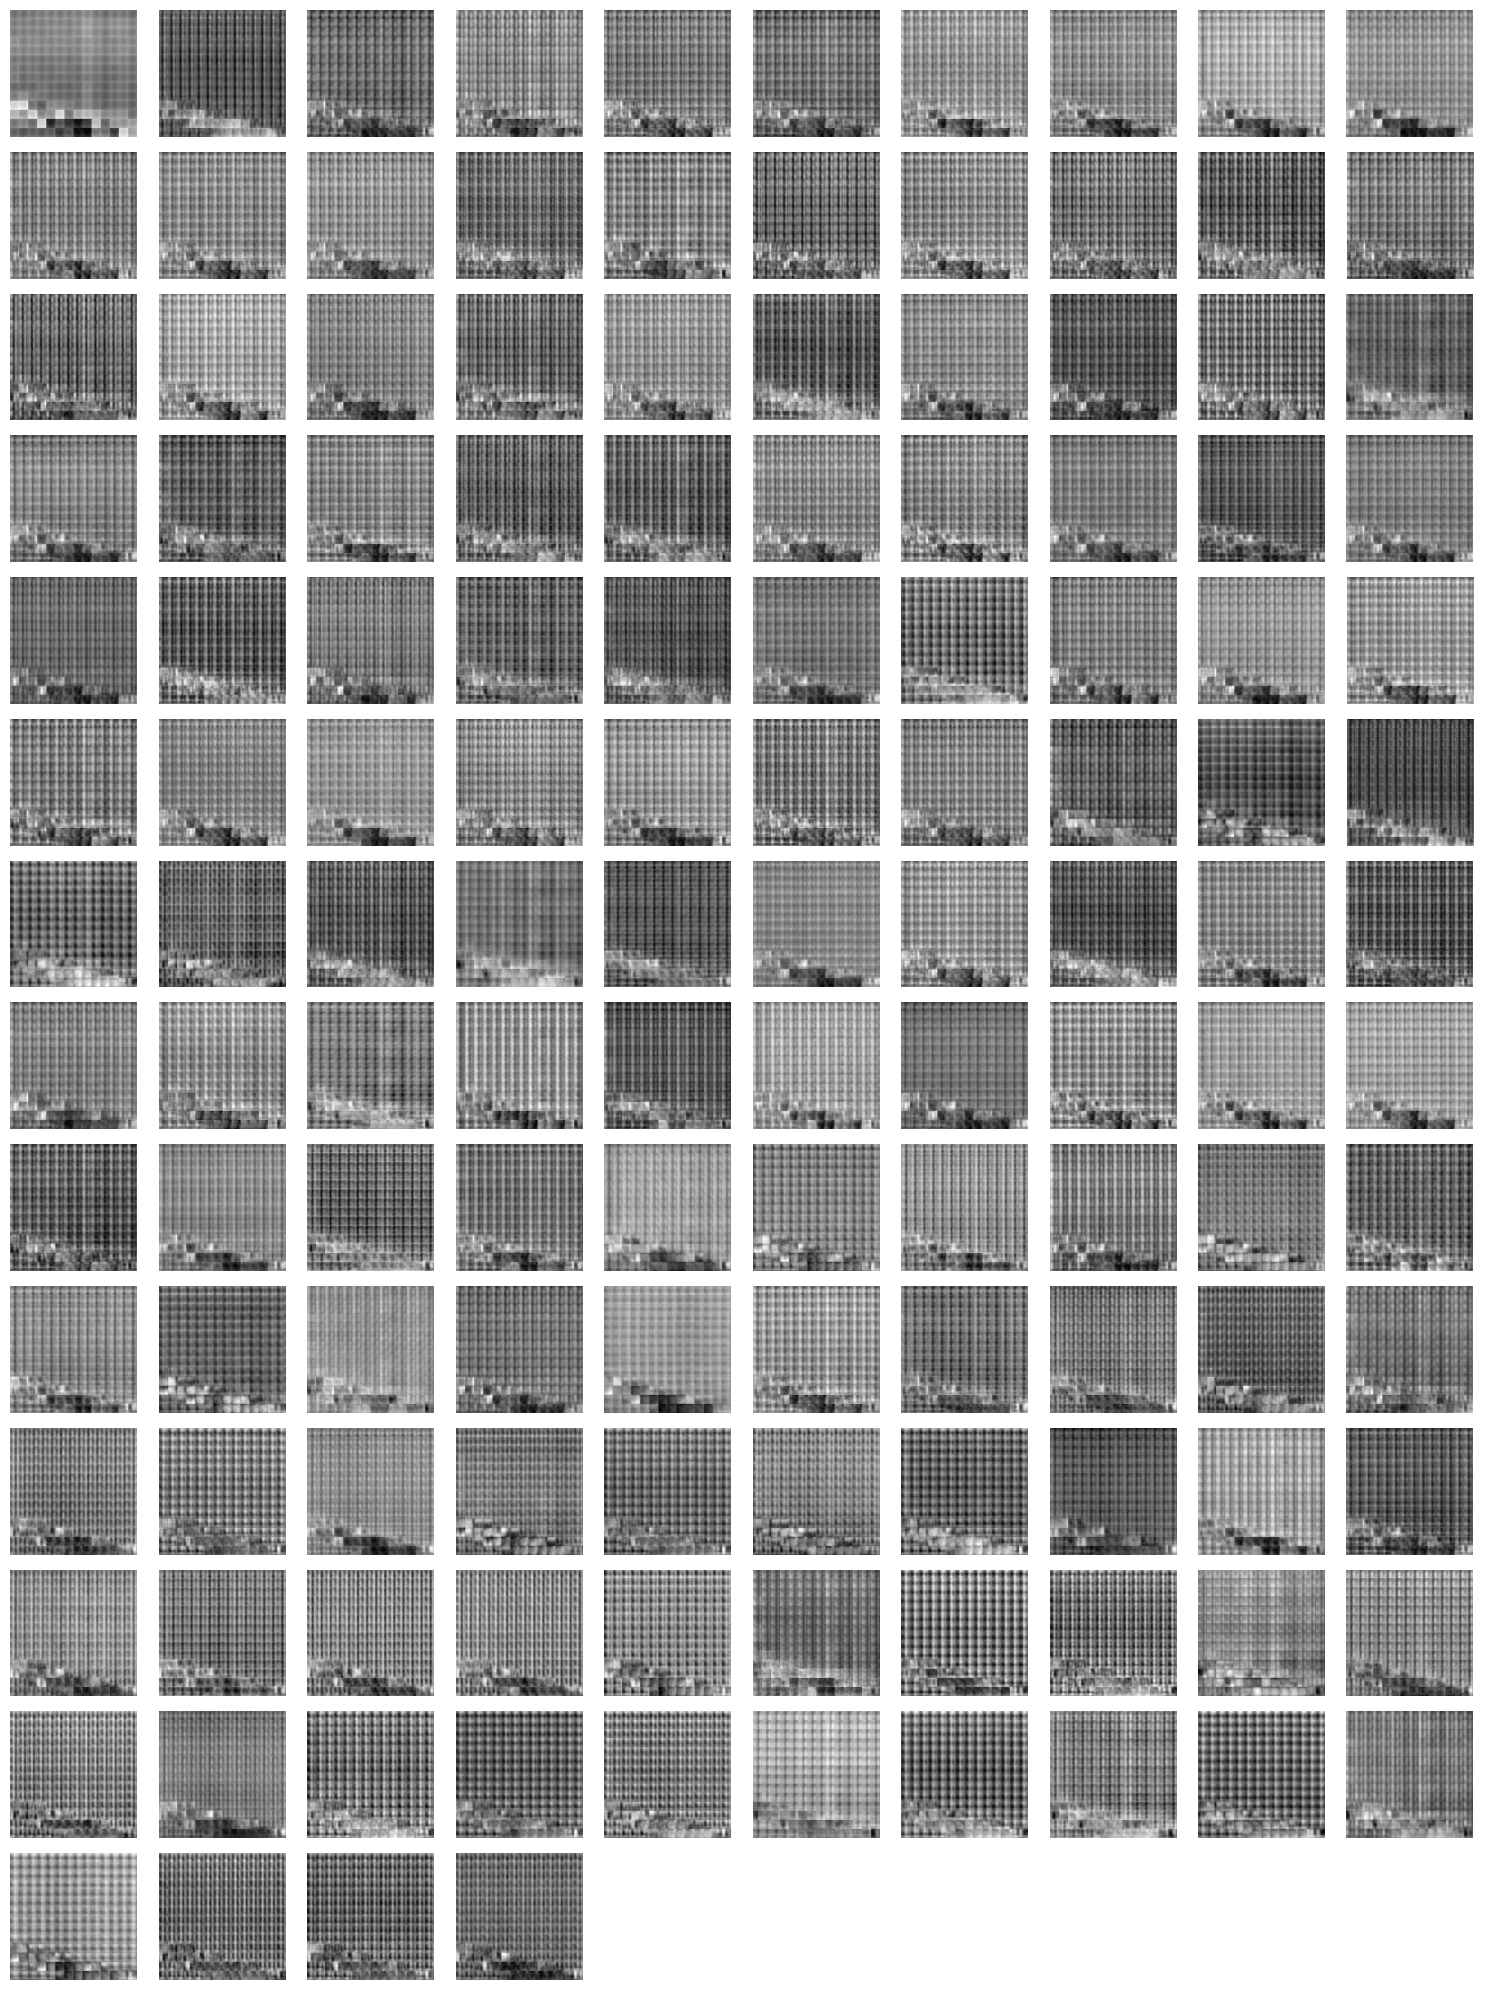

In [12]:
image_channels = out_rgb_b3hw[0]  # Shape: [134, 224, 224]

# Number of channels
num_channels = image_channels.shape[0]

# Set up the plot grid (e.g., 14x10 for 134 channels)
fig, axes = plt.subplots(nrows=14, ncols=10, figsize=(15, 20))
axes = axes.flatten()

# Plot each channel
for i in range(num_channels):
    ax = axes[i]
    ax.imshow(image_channels[i].detach().cpu().numpy(), cmap='gray')
    ax.axis('off')
    
# Hide any unused subplots
for j in range(num_channels, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

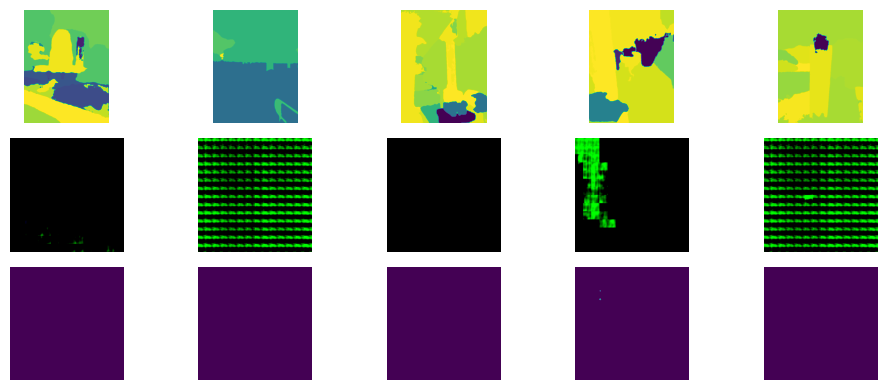

In [23]:
fig, axs = plt.subplots(3, 5, figsize=(10, 4))

for i, image_path in enumerate(selected_images):
    image = Image.open(image_path)
    axs[0, i].imshow(image)
    axs[0, i].axis('off')

for i, tensor in enumerate(out_rgb_b3hw[:,0:3]):
    tensor = torch.clamp(tensor, 0, 1)
    axs[1, i].imshow(tensor.cpu().permute(1, 2, 0).detach().numpy())
    axs[1, i].axis('off')
    
for i, tensor in enumerate(out_rgb_b3hw):
    summed_tensor = torch.sum(tensor, dim=0)
    tensor = torch.clamp(summed_tensor, 0, 1)
    axs[2, i].imshow(tensor.cpu().detach().numpy())
    axs[2, i].axis('off')
    

plt.tight_layout() 
plt.show()

### SAM

In [19]:
import paintmind as pm
from PIL import Image
import glob
import random
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import torchvision.transforms as transforms
import warnings
warnings.filterwarnings("ignore")

In [144]:
k = []

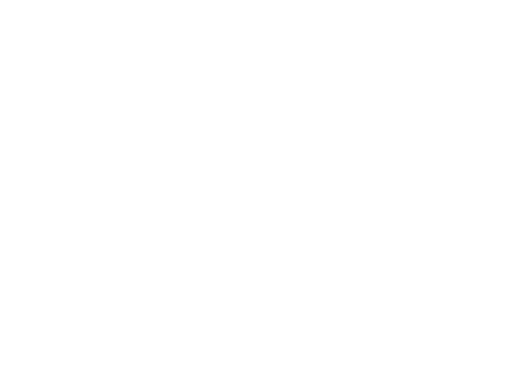

In [198]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
from typing import List, Tuple

def run_length_decode(rle: str, shape: Tuple[int, int]) -> np.ndarray:
    """
    Decodes a run-length encoded string into a binary mask.
    
    Args:
    - rle (str): Run-length encoded string.
    - shape (Tuple[int, int]): The shape of the mask (height, width).
    
    Returns:
    - np.ndarray: The decoded binary mask.
    """
    s = list(map(int, rle.split()))
    starts, lengths = s[0::2], s[1::2]
    starts = np.array(starts) - 1  # Convert to 0-based indexing
    ends = starts + lengths
    mask = np.zeros(shape[0] * shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        mask[lo:hi] = 1
    return mask.reshape(shape)

def extract_labels_and_iou(file_path: str) -> Tuple[List[str], List[float]]:
    """
    Extract label names and IoU predictions from the file.
    
    Args:
    - file_path (str): The path to the file.
    
    Returns:
    - Tuple[List[str], List[float]]: The extracted label names and IoU predictions.
    """
    with open(file_path, 'r') as file:
        lines = file.readlines()
    
    # Extract label names (first line)
    label_names = eval(lines[0].strip().split('Objects: ')[1].strip())
    
    # Extract IoU predictions (last line)
    iou_predictions = eval(lines[-1].strip().split('iou_predictions: ')[1].strip())
    return label_names, iou_predictions

def overlay_masks_and_labels(image: np.ndarray, masks_info: str, label_names: List[str], iou_predictions: List[float]) -> np.ndarray:
    """
    Overlay masks and labels on an image.
    
    Args:
    - image (np.ndarray): The image on which to overlay masks.
    - masks_info (str): The mask information string.
    - label_names (List[str]): The list of label names.
    - iou_predictions (List[float]): The list of IoU predictions for each label.
    
    Returns:
    - np.ndarray: The image with overlaid masks and labels.
    """
    # Decode masks
    masks = {}
    lines = masks_info.splitlines()
    for line in lines:
        if line.startswith('Label'):
            label_id = int(line.split(':')[0].split()[1])
            encoded_mask = line.split(':')[1].strip()
            masks[label_id] = run_length_decode(encoded_mask, image.shape[:2])
    
    # Overlay masks and labels on the image
    color_image = np.ones_like(image) * 255
    
    for label_id, mask in masks.items():
        color = np.random.randint(0, 255, size=3).tolist()  # Random color for each mask
        
        # Draw contours for better visualization
        contours, _ = cv2.findContours(mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cv2.drawContours(color_image, contours, -1, color, 2)
        
        # Fill the mask area with a semi-transparent color
        color_mask = np.zeros_like(image)
        color_mask[mask == 1] = color
        alpha = 0.3 # Adjusted transparency factor for more transparency
        color_image = cv2.addWeighted(color_image, 1 - alpha, color_mask, alpha, 0)
        
        # Draw text labels
        label_name = label_names[label_id]
#         iou_score = iou_predictions[label_id]
        text = f'{label_name}'
        
        # Put text at a location inside the mask region
        moments = cv2.moments(mask.astype(np.uint8))
        if moments['m00'] != 0:
            cx = int(moments['m10'] / moments['m00'])
            cy = int(moments['m01'] / moments['m00'])
        else:
            cx, cy = 10, 30 + 20 * label_id
        
        cv2.putText(color_image, text, (cx - 100, cy), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
    
    return color_image

def main(image_path: str):
    # Construct SAM path from image path
    base_path = '/mnt/SSD1/Niantic/'
    sam_path = image_path.replace('/data/', '/sam/').replace('.jpg', '.txt')
    
    # Load image
    image = cv2.imread(image_path)
    
    # Extract labels and IoU predictions
    label_names, iou_predictions = extract_labels_and_iou(sam_path)
    
    # Read SAM mask info
    with open(sam_path, 'r') as file:
        lines = file.readlines()
    masks_info = ''.join(lines[1:-1])  # Exclude label names and IoU predictions
    
    # Process image and masks
    result_image = overlay_masks_and_labels(image, masks_info, label_names, iou_predictions)
    
    # Display result
    result = cv2.cvtColor(result_image, cv2.COLOR_BGR2RGB)
#     print(result)
    # Save result as a PNG file
    plt.imsave("result_grayscale_3.png", result)
    plt.axis('off')
#     plt.show()

if __name__ == "__main__":
    image_path = k[3]
    k.append(image_path)
    main(image_path)

In [21]:
images = glob.glob("/mnt/SSD1/Niantic/data/val/**/**/*.jpg")
seed_number = 480
random.seed(seed_number)
random.shuffle(images)
selected_images = images[:5]

In [22]:
selected_images[0]

'/mnt/SSD1/Niantic/data/val/s00523/seq1/frame_00543.jpg'

In [183]:
from fourm.vq.vqvae import VQVAE, DiVAE
from PIL import Image
import torch.nn as nn
from torchvision import transforms
from fourm.utils import denormalize, IMAGENET_INCEPTION_MEAN, IMAGENET_INCEPTION_STD
from torchvision.transforms import Normalize
transform = transforms.ToTensor()
resize = transforms.Resize((224, 224))

In [184]:
tok = VQVAE.from_pretrained('EPFL-VILAB/4M_tokenizers_sam-instance_1k_64')
normalize = Normalize(mean=IMAGENET_INCEPTION_MEAN[0], std=IMAGENET_INCEPTION_STD[0])

In [185]:
tensors_b3hw = []
selected_images = ["result_grayscale.png","result_grayscale_1.png","result_grayscale_2.png","result_grayscale_3.png"]
for image_path in selected_images :
    image = Image.open(image_path).convert('L')
    rgb_b3hw = transform(resize(image)).unsqueeze(0)  
    tensors_b3hw.append(rgb_b3hw)
stacked_tensors_b3hw = torch.cat(tensors_b3hw, dim=0).float()

In [186]:
print(stacked_tensors_b3hw.dtype)
print(squeezed_tensor.min(), squeezed_tensor.max())

torch.float32
tensor(0.) tensor(1.)


In [191]:
_, _, tokens = tok.encode(stacked_tensors_b3hw)
image_size = rgb_b3hw.shape[-1]
output_rgb_b3hw  = tok.decode_tokens(tokens, image_size=image_size)
out_rgb_b3hw = denormalize(output_rgb_b3hw, mean=IMAGENET_INCEPTION_MEAN[0:1], std=IMAGENET_INCEPTION_STD[0:1])

In [188]:
k

['/mnt/SSD1/Niantic/data/val/s00464/seq1/frame_00001.jpg',
 '/mnt/SSD1/Niantic/data/val/s00465/seq1/frame_00001.jpg',
 '/mnt/SSD1/Niantic/data/val/s00467/seq1/frame_00001.jpg',
 '/mnt/SSD1/Niantic/data/val/s00468/seq1/frame_00001.jpg',
 '/mnt/SSD1/Niantic/data/val/s00468/seq1/frame_00001.jpg',
 '/mnt/SSD1/Niantic/data/val/s00467/seq1/frame_00001.jpg',
 '/mnt/SSD1/Niantic/data/val/s00465/seq1/frame_00001.jpg',
 '/mnt/SSD1/Niantic/data/val/s00464/seq1/frame_00001.jpg',
 '/mnt/SSD1/Niantic/data/val/s00464/seq1/frame_00001.jpg',
 '/mnt/SSD1/Niantic/data/val/s00465/seq1/frame_00001.jpg',
 '/mnt/SSD1/Niantic/data/val/s00467/seq1/frame_00001.jpg',
 '/mnt/SSD1/Niantic/data/val/s00468/seq1/frame_00001.jpg']

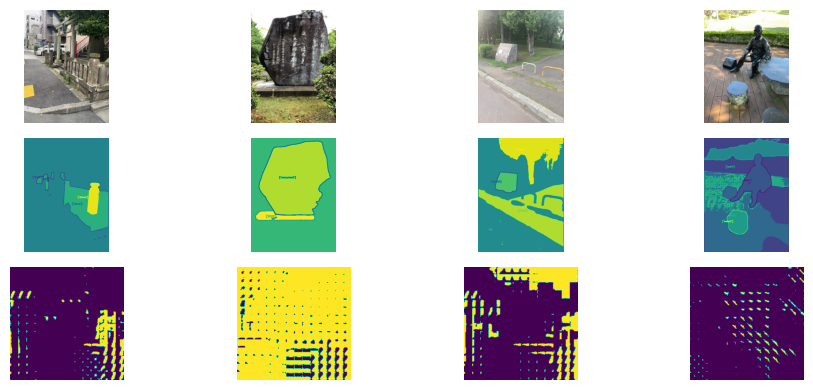

In [193]:
fig, axs = plt.subplots(3, 4, figsize=(10, 4))

for i, image_path in enumerate(k[:4]):
    image = Image.open(image_path)
    axs[0, i].imshow(image)
    axs[0, i].axis('off')
    
for i, image_path in enumerate(selected_images):
    image = Image.open(image_path).convert('L')
    axs[1, i].imshow(image)
    axs[1, i].axis('off')

for i, tensor in enumerate(out_rgb_b3hw):
    tensor = torch.clamp(tensor, 0, 1)
    axs[2, i].imshow(tensor.cpu().permute(1, 2, 0).detach().numpy())
    axs[2, i].axis('off')
    
    

plt.tight_layout() 
plt.show()